## Confidentiality

This notebook is downloaded from Quantopian and is for demonstrational purposes only.

Please do not copy or distribute this notebook.

## Introduction

This notebook can't be run in Google Colab and should be run in Quantopian Research and Quantopian IDE.

## Interpreting Alphalens Tear Sheets

Previously was described how to query and process data so that you can analyze it with Alphalens tear sheets. Here, a few iterations are described of the alpha discovery phase of the quant workflow by analyzing those tear sheets.

Next, a few things are done:

1. Analyzing how well an alpha factor predicts future price movements with create_information_tear_sheet().
2. Trying to improve the original alpha factor by combining it with another alpha factor.
3. Previewing how profitable the alpha factor might be with create_returns_tear_sheet().

### Starting Alpha Factor

The following code expresses an alpha factor based on a company's net income and market cap, then creates an information tear sheet for that alpha factor. The alpha factor is analyzed by looking at it's information coefficient (IC). The IC is a number ranging from -1, to 1, which quantifies the predictiveness of an alpha factor. Any number above 0 is considered somewhat predictive.

The first number you should look at is the IC mean, which is an alpha factor's average IC over a given time period. You want the factor's IC Mean to be as high as possible. Generally speaking, a factor is worth investigating if it has an IC mean over 0. If it has an IC mean close to .1 (or higher) over a large trading universe, that factor is probably very good. In fact, you probably want to check to make sure there isn't some lookahead bias if your alpha factor's IC mean is over .1

**Running the cell below creates an information tear sheet for the alpha factor. Notice how the IC Mean figures (the first numbers on the first chart) are all positive. 

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.006,0.007,0.006
IC Std.,0.106,0.105,0.097
Risk-Adjusted IC,0.058,0.063,0.063
t-stat(IC),1.313,1.409,1.414
p-value(IC),0.190,0.159,0.158
IC Skew,0.005,0.146,0.119
IC Kurtosis,-0.177,-0.210,-0.593


/venvs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<Figure size 1008x576 with 0 Axes>

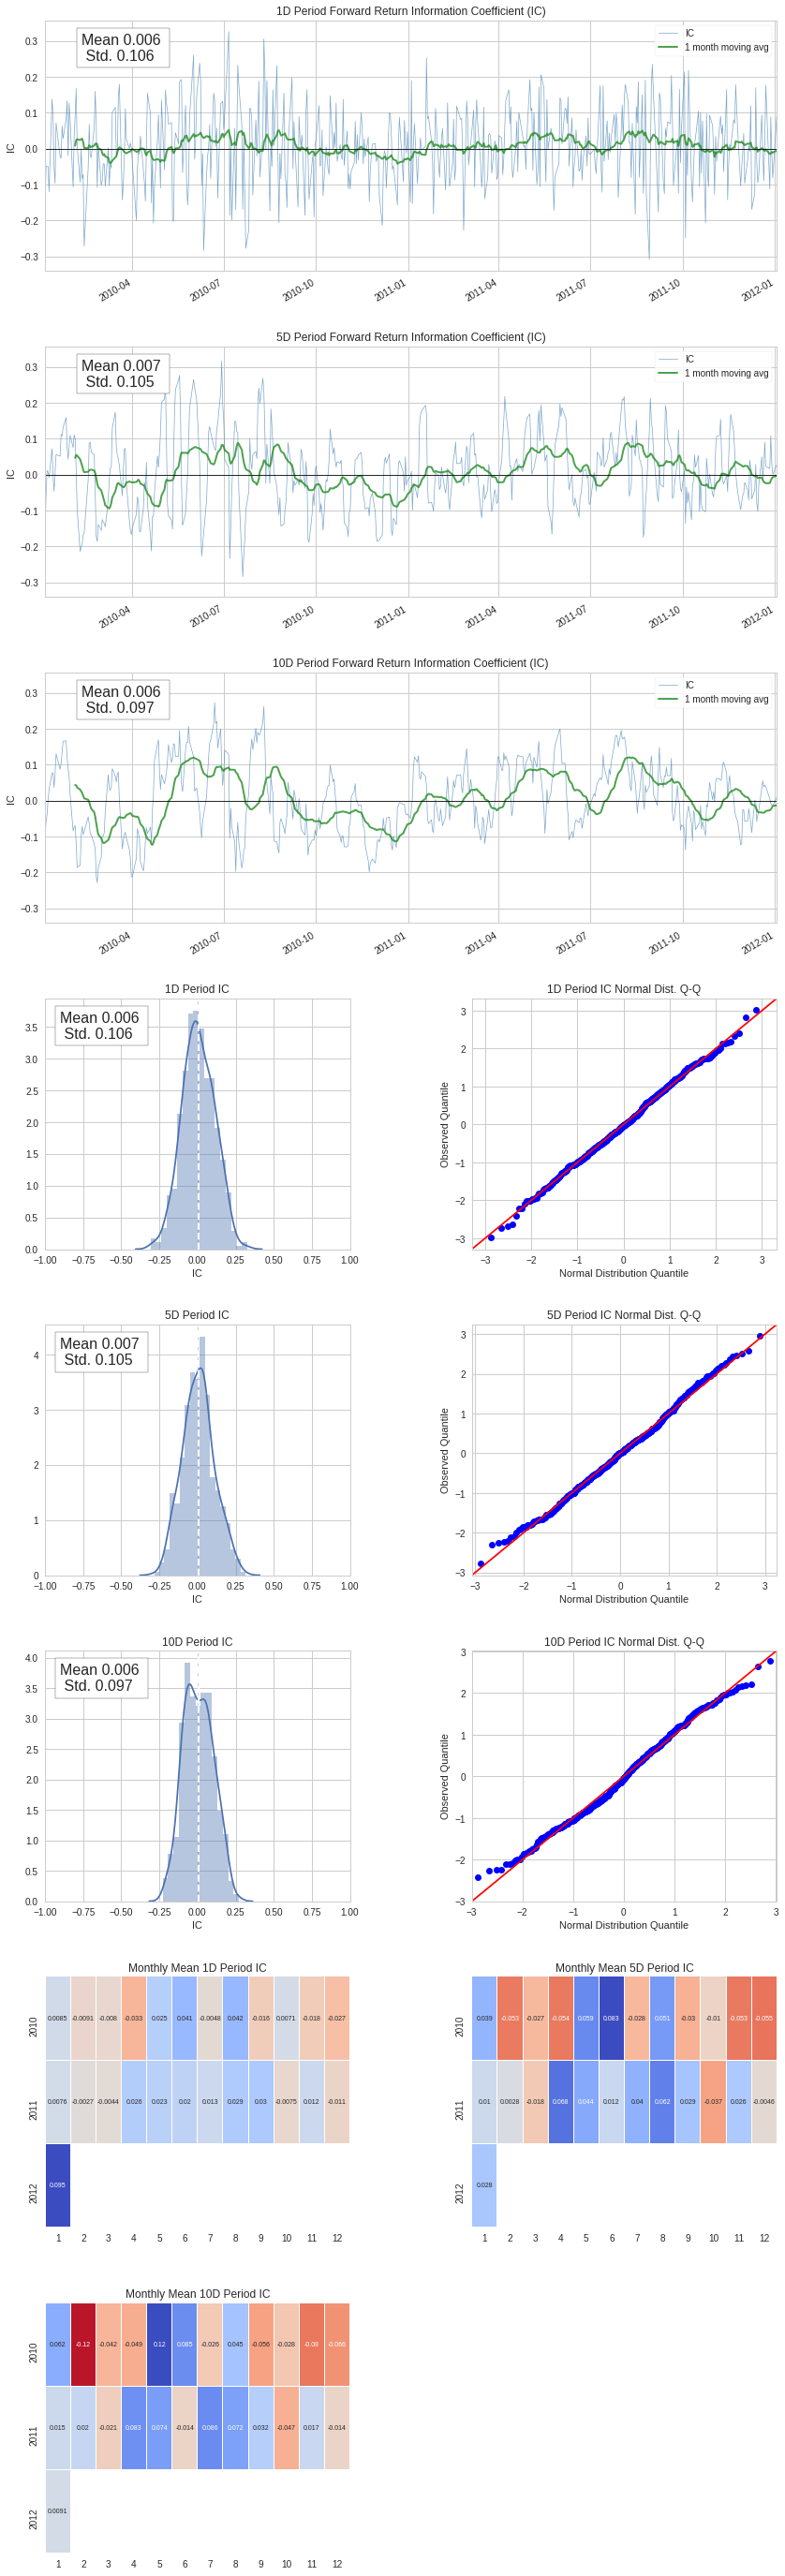

In [ ]:
from quantopian.pipeline.data import factset
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns


def make_pipeline():
    
    # 1 year moving average of year over year net income
    net_income_moving_average = SimpleMovingAverage( 
        inputs=[factset.Fundamentals.net_inc_af], 
        window_length=252
    )
    
    # 1 year moving average of market cap
    market_cap_moving_average = SimpleMovingAverage( 
        inputs=[factset.Fundamentals.mkt_val], 
        window_length=252
    )
    
    average_market_cap_per_net_income = (market_cap_moving_average / net_income_moving_average)
    
    # the last quarter's net income
    net_income = factset.Fundamentals.net_inc_qf.latest 
    
    projected_market_cap = average_market_cap_per_net_income * net_income
    
    return Pipeline(
        columns = {'projected_market_cap': projected_market_cap},
        screen = QTradableStocksUS() & projected_market_cap.notnull()
    )


pipeline_output = run_pipeline(make_pipeline(), '2010-1-1', '2012-1-1')
pricing_data = get_pricing(pipeline_output.index.levels[1], '2010-1-1', '2012-2-1', fields='open_price')
factor_data = get_clean_factor_and_forward_returns(pipeline_output, pricing_data)

create_information_tear_sheet(factor_data)

### Adding Another Alpha Factor

Alphalens is useful for identifying alpha factors that aren't predictive early in the quant workflow. This allows to avoid wasting time running a full backtest on a factor that could have been discarded earlier in the process.

Running the following cell to express another alpha factor called `price_to_book`, combining it with `projected_market_cap` using zscores and winsorization, then creating another information tearsheet based on the new (and hopefully improved) alpha factor. 

Notice how the IC figures are lower than they were in the first chart. That means the factor added is making the predictions worse!

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.008,0.015,0.025
IC Std.,0.095,0.106,0.102
Risk-Adjusted IC,0.084,0.142,0.243
t-stat(IC),1.218,2.051,3.518
p-value(IC),0.225,0.042,0.001
IC Skew,-0.017,0.015,-0.256
IC Kurtosis,-0.225,-0.409,-0.727


<Figure size 1008x576 with 0 Axes>

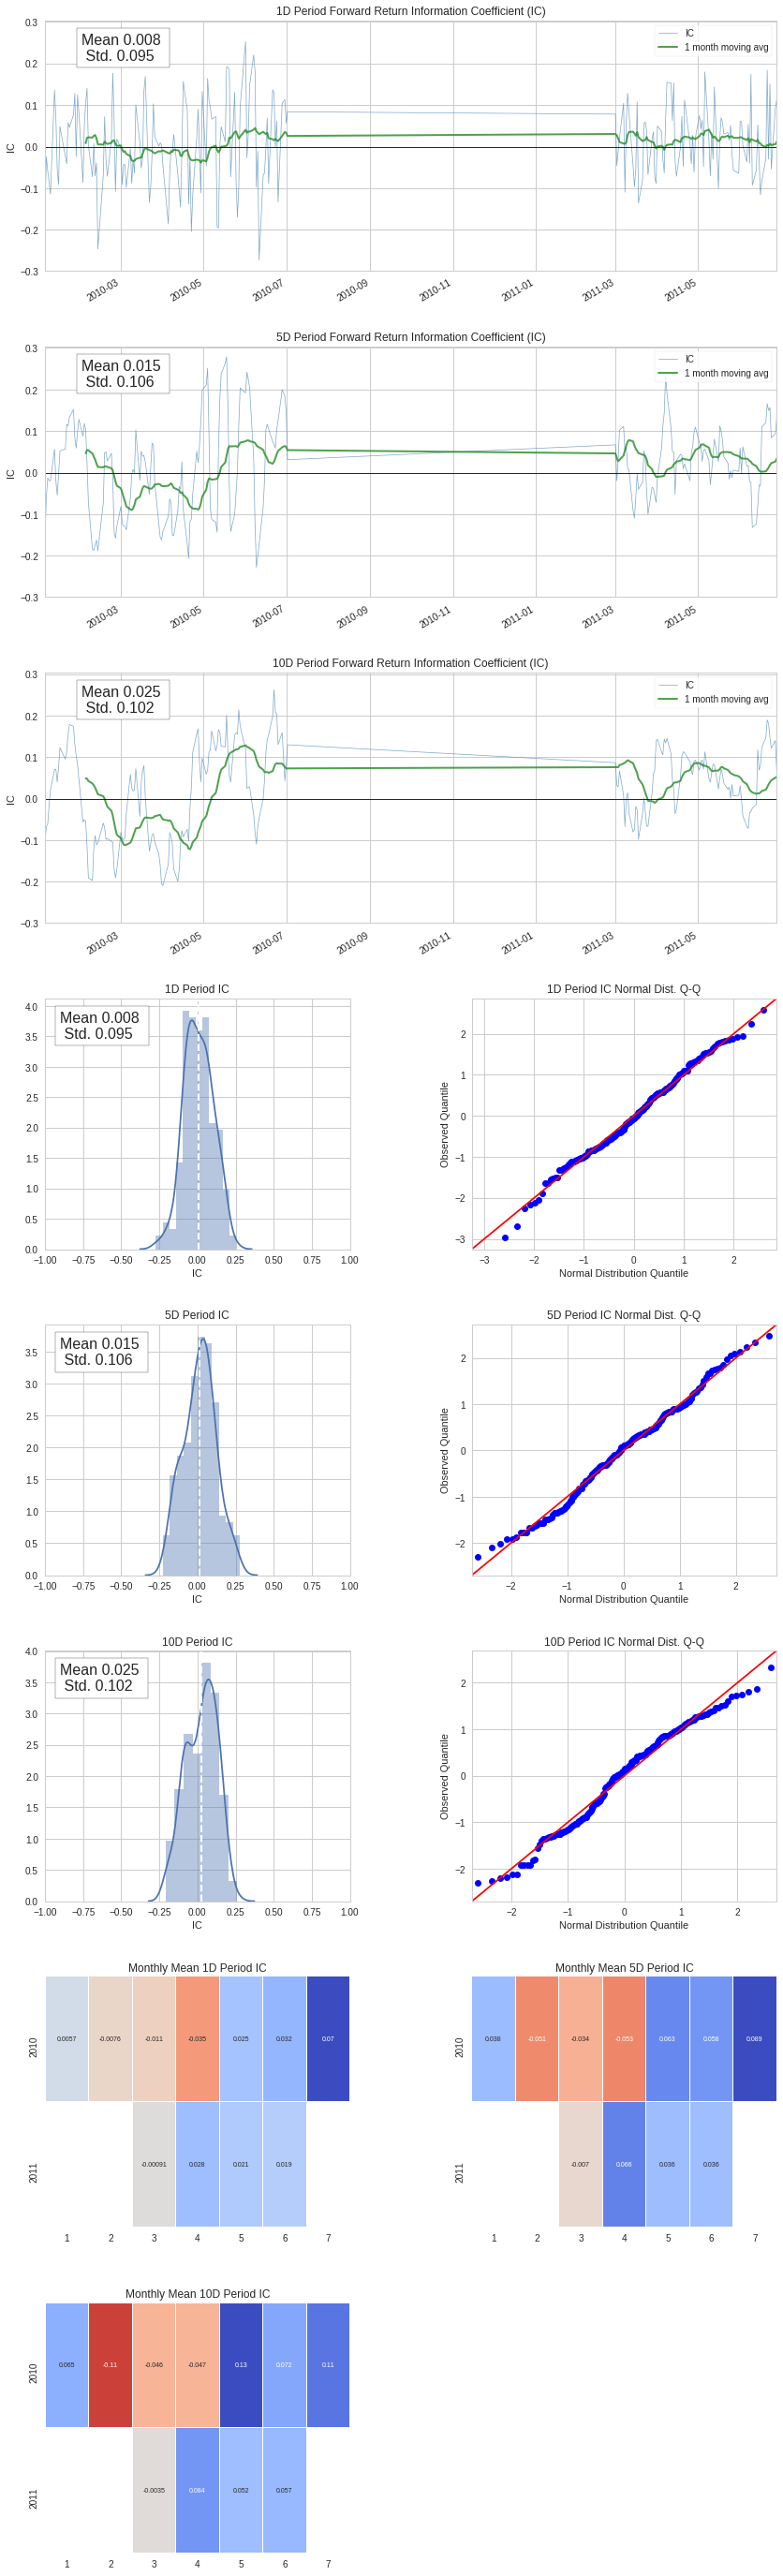

In [ ]:
def make_pipeline():

    net_income_moving_average = SimpleMovingAverage( # 1 year moving average of year over year net income
        inputs=[factset.Fundamentals.net_inc_af], 
        window_length=252
    )
    
    market_cap_moving_average = SimpleMovingAverage( # 1 year moving average of market cap
        inputs=[factset.Fundamentals.mkt_val], 
        window_length=252
    )
    
    average_market_cap_per_net_income = (market_cap_moving_average / net_income_moving_average)
    
    net_income = factset.Fundamentals.net_inc_qf.latest # the last quarter's net income
    
    projected_market_cap = average_market_cap_per_net_income * net_income
    
    price_to_book = factset.Fundamentals.pbk_qf.latest
    
    factor_to_analyze = projected_market_cap.zscore() + price_to_book.zscore()
    
    return Pipeline(
        columns = {'factor_to_analyze': factor_to_analyze},
        screen = QTradableStocksUS() & factor_to_analyze.notnull()
    )



pipeline_output = run_pipeline(make_pipeline(), '2010-1-1', '2012-1-1')
pricing_data = get_pricing(pipeline_output.index.levels[1], '2010-1-1', '2012-2-1', fields='open_price')
new_factor_data = get_clean_factor_and_forward_returns(pipeline_output, pricing_data)

create_information_tear_sheet(new_factor_data)

### Seeing If the Alpha Factor Might Be Profitable

The first iteration of the alpha factor had more predictive value than the second one. Let's see if the original alpha factor might make any money.

`create_returns_tear_sheet()` splits your universe into quantiles, then shows the returns generated by each quantile over different time periods. Quantile 1 is the 20% of assets with the lowest alpha factor values, and quantile 5 is the highest 20%.

This function creates six types of charts, but the two most important ones are:

- **Mean period-wise returns by factor quantile:** This chart shows the average return for each quantile in your universe, per time period. You want the quantiles on the right to have higher average returns than the quantiles on the left.
- **Cumulative return by quantile:** This chart shows how each quantile performed over time. You want to see quantile 1 consistently performing the worst, quantile 5 consistently performing the best, and the other quantiles in the middle.

**Running the following cell, presents how quantile 5 doesn't have the highest returns. Ideally, you want quantile 1 to have the lowest returns, and quantile 5 to have the highest returns. 

Returns Analysis


,1D,5D,10D
Ann. alpha,-0.063,-0.035,-0.055
beta,-0.012,-0.038,-0.040
Mean Period Wise Return Top Quantile (bps),-1.205,-1.391,-1.424
Mean Period Wise Return Bottom Quantile (bps),-0.581,-0.558,-0.704
Mean Period Wise Spread (bps),-0.624,-0.819,-0.701


<Figure size 1008x576 with 0 Axes>

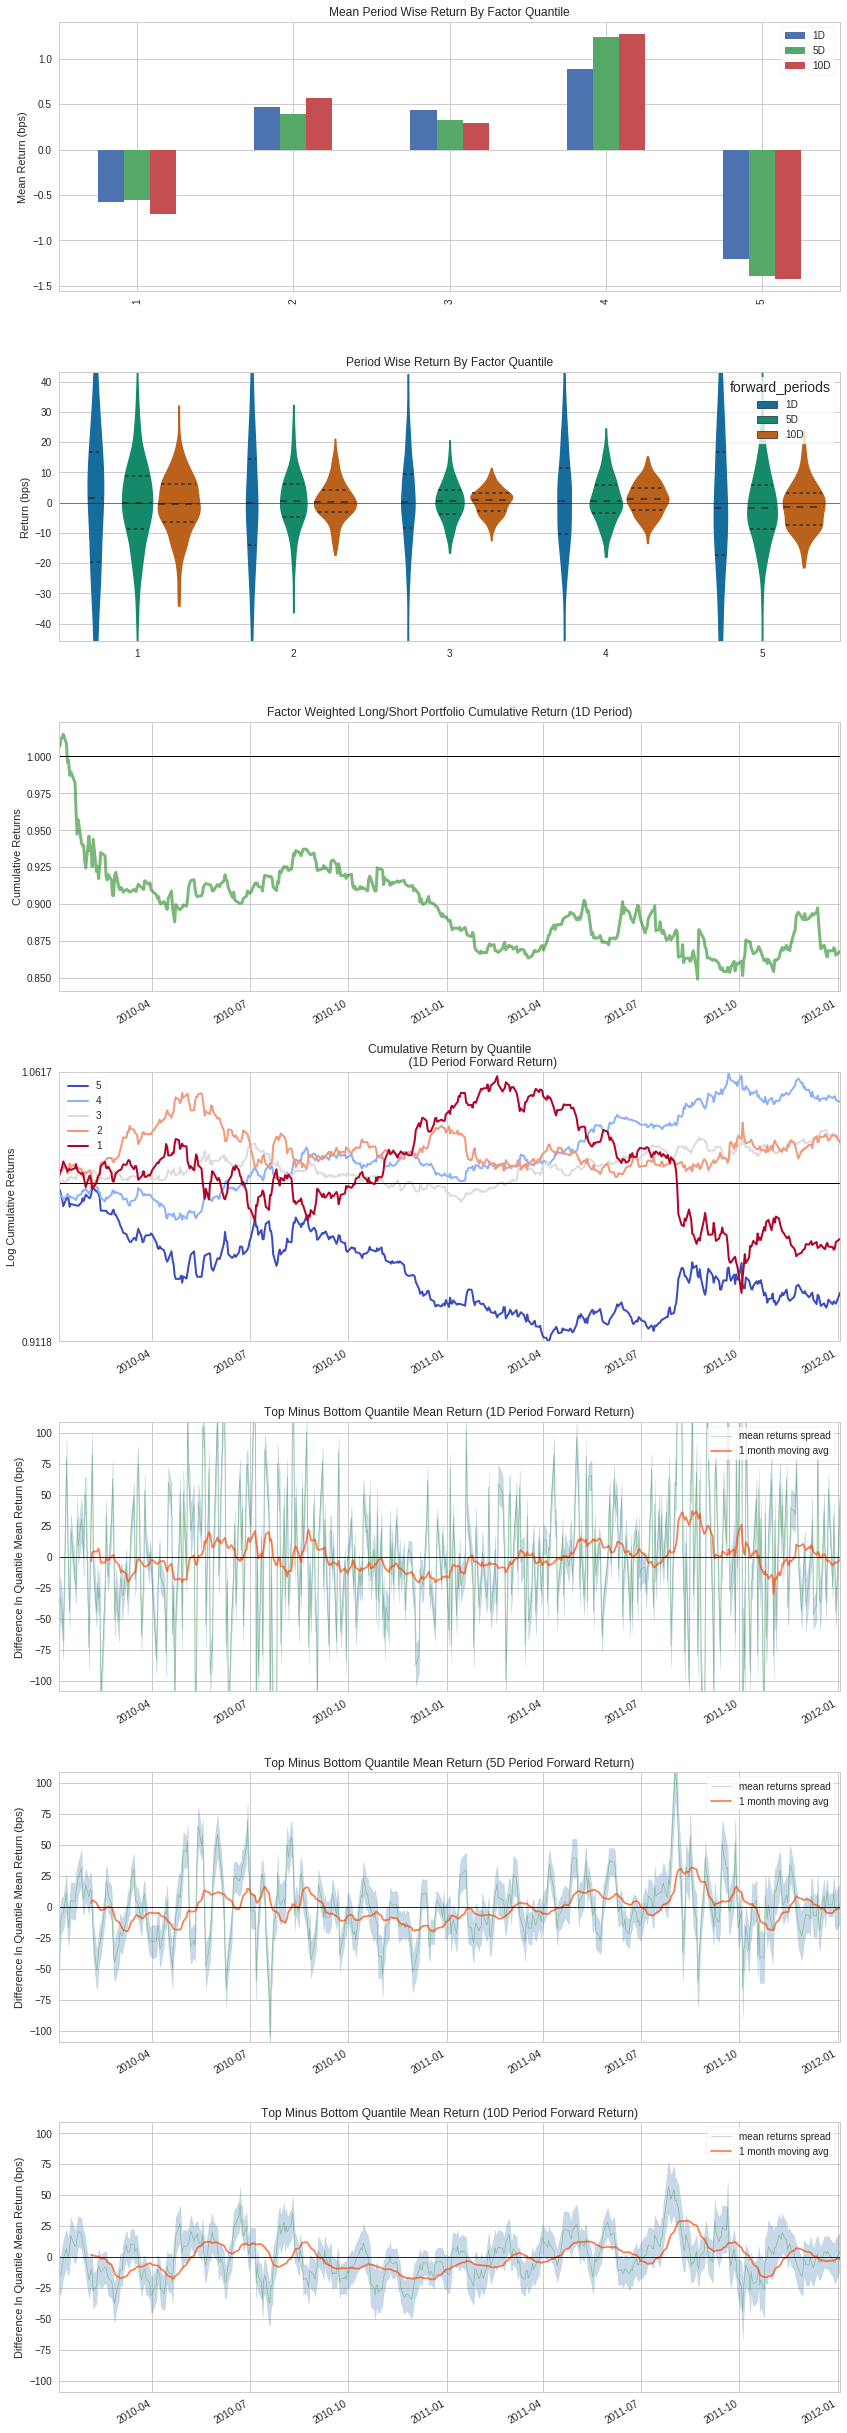

In [ ]:
from alphalens.tears import create_returns_tear_sheet

create_returns_tear_sheet(factor_data)